# ML Clustering with K-means

Clustering is the task of dividing the population or data points into several groups such that data points in the same groups are more similar to other data points in the same group and dissimilar to the data points in different groups. On a fundamental level, it is a collection of objects based on similarities and dissimilarities between them.

When working with sales data, a common thing to do is to understand the customers' buying patterns using 3 parameters: Monetary (amount of money spent), Frequency (how frequently the customer bought something) Recency (how many days has passed from today to their last purchase).

## Import:

In [85]:
# Import libraries:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter

## Connection to the SQL Database:

In [48]:
# connecting to the database
connection = sqlite3.connect("DB_browser/SuperStore.db")

print("Connected to the database")

Connected to the database


## Creating a Function to display a query in a Dataframe:

In [49]:
# Display the query in a dataframe
def sql_to_dataframe(query):
    df = pd.read_sql(query, connection)
    return df

## Dataframe for the Clustering:
First, we will create a new DataFrame by grouping the customers based on their ID and summing the Sales and same with Frequency (How many unique Order IDs are there per customer?) and the Recency (Calculate it from the last order date in the dataset) and then merge all the 3 DataFrames.

In [50]:
customers_sales_frequencey_recency = '''
                                        SELECT 
                                            o.CustomerId, 
                                            ROUND(SUM(od.Sales), 2)'Amount',
                                            COUNT(od.OrderId)'Frequency',
                                            JULIANDAY('2017-12-30') - JULIANDAY(MAX(od.OrderDate))'Recency'
                                        FROM Orders_details AS od
                                        JOIN Orders AS o
                                        ON od.OrderId = o.OrderId
                                        GROUP BY CustomerId;
                                    '''
                                    
df = sql_to_dataframe(customers_sales_frequencey_recency)
display(df)
display(df.dtypes)


,CustomerId,Amount,Frequency,Recency
0,AA-10315,5563.56,11,184.0
1,AA-10375,1056.39,15,19.0
2,AA-10480,1790.51,12,259.0
3,AA-10645,5086.94,18,55.0
4,AB-10015,886.16,6,415.0
...,...,...,...,...
788,XP-21865,2374.66,28,43.0
789,YC-21895,5454.35,8,4.0
790,YS-21880,6720.44,12,9.0
791,ZC-21910,8025.71,31,54.0


CustomerId     object
Amount        float64
Frequency       int64
Recency       float64
dtype: object

### Converting the column 'Recency' into Integer Data type:

In [51]:
# Converting datatype column
df['Recency'] = pd.to_numeric(df['Recency'], errors='coerce').astype('Int64')

In [52]:
df.head()

,CustomerId,Amount,Frequency,Recency
0,AA-10315,5563.56,11,184
1,AA-10375,1056.39,15,19
2,AA-10480,1790.51,12,259
3,AA-10645,5086.94,18,55
4,AB-10015,886.16,6,415


## Dealing with outliers:
Try to visualize with a boxplot these 3 parameters: are there outliers? Because of its nature, the K-Means algorithm is susceptible to outliers.

In [53]:
# Create subplots with 1 row and 3 columns
fig = make_subplots(rows=1, cols=3)

# Add box plots to each subplot
for i, col in enumerate(['Amount', 'Frequency', 'Recency'], start=1):
    fig.add_trace(
        go.Box(y=df[col], name=col),
        row=1, col=i
    )

# Update layout
fig.update_layout(title='Boxplots of Amount, Frequency, and Recency')

# Show figure
fig.show()

### Removing the Outliers for each features:
Remove each feature's (statistical) outliers using the Interquartile Range (IQR is the difference between the upper quartile and the lower quartile).

#### Amount Outliers:

In [54]:
# Calculate the IQR for each feature
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1

# Filter the data to remove outliers for this feature
filtered_df = df[
    ~((df['Amount'] < (Q1 - 1.5 * IQR)) | (df['Amount'] > (Q3 + 1.5 * IQR)))
]

# Display the filtered DataFrame
display(filtered_df.shape)

(750, 4)

#### Frequency Outliers:

In [55]:
# Calculate the IQR for each feature
Q1 = filtered_df['Frequency'].quantile(0.25)
Q3 = filtered_df['Frequency'].quantile(0.75)
IQR = Q3 - Q1

# Filter the data to remove outliers for this feature
filtered_df = filtered_df[
    ~((filtered_df['Frequency'] < (Q1 - 1.5 * IQR)) | (filtered_df['Frequency'] > (Q3 + 1.5 * IQR)))
]

# Display the filtered DataFrame
display(filtered_df.shape)

(730, 4)

#### Recency Outliers:

In [56]:
# Calculate the IQR for each feature
Q1 = filtered_df['Recency'].quantile(0.25)
Q3 = filtered_df['Recency'].quantile(0.75)
IQR = Q3 - Q1

# Filter the data to remove outliers for this feature
filtered_df = filtered_df[
    ~((filtered_df['Recency'] < (Q1 - 1.5 * IQR)) | (filtered_df['Recency'] > (Q3 + 1.5 * IQR)))
]

# Display the filtered DataFrame
display(filtered_df.shape)

(663, 4)

#### Checking the results with a Boxplot:

In [57]:
# Create subplots with 1 row and 3 columns
fig = make_subplots(rows=1, cols=3)

# Add box plots to each subplot
for i, col in enumerate(['Amount', 'Frequency', 'Recency'], start=1):
    fig.add_trace(
        go.Box(y=filtered_df[col], name=col),
        row=1, col=i
    )

# Update layout
fig.update_layout(title='Boxplots of Amount, Frequency, and Recency')

# Show figure
fig.show()

## Feature scaling:
Because of the nature of the algorithm, it is crucial to rescale the variables so that they have a comparable scale. There are two common ways of rescaling: Min-Max scaling Standardisation (mean-0, sigma-1).

This step is important to put the values of the different columns on the same scale. 

Here, we will use Standardisation Scaling.



In [66]:
# Rescaling the attributes
data = filtered_df[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
data_scale = scaler.fit_transform(data)
data_scale.shape

# Coverting to a Dataframe
data_scale = pd.DataFrame(data_scale)
data_scale.columns = ['Amount', 'Frequency', 'Recency']
# Display the first rows of the Scale dataframe
display(data_scale.head())
display(data_scale.shape)

,Amount,Frequency,Recency
0,1.841594,-0.231602,0.826249
1,-0.851013,0.535200,-0.811889
2,-0.412446,-0.039901,1.570857
3,1.556859,1.110301,-0.454477
4,-0.952710,-1.190104,3.119642


(663, 3)

## Building the model:
K-means clustering is one of the simplest and most popular unsupervised machine learning algorithms. The algorithm works as follows:

- First, we randomly initialize k points, called means. In this case, we will use 4 as a value.

- We categorize each item to its closest mean and update the mean's coordinates, which are the averages of the items categorized in that mean so far.

- We repeat the process for a given number of iterations, and, in the end, we have our clusters.

In [70]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50, n_init='auto')
kmeans.fit(data_scale)

KMeans(max_iter=50, n_clusters=4, n_init='auto')

In [73]:
# Assign the labels to each data point
kmeans.labels_
label_list=kmeans.labels_
sorted(Counter(label_list).items())

[(0, 250), (1, 143), (2, 105), (3, 165)]

## Finding the optimal number of clusters:

There are two methods to determine the best k: the Elbow method and the Silhouette analysis.

According to the article Elbow Method for optimal value of k in KMeans, " a fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k."

Although our first thought might be that increasing the number of parameters (k) will improve the fit of our model, we risk over fitting it. The Elbow Curve will help us identify when, if we were to add more clusters, it would only add so much more information to our model. The optimal k value will be where the average distance falls off suddenly. Which is when the curve starts to become parallel to the x-axis.

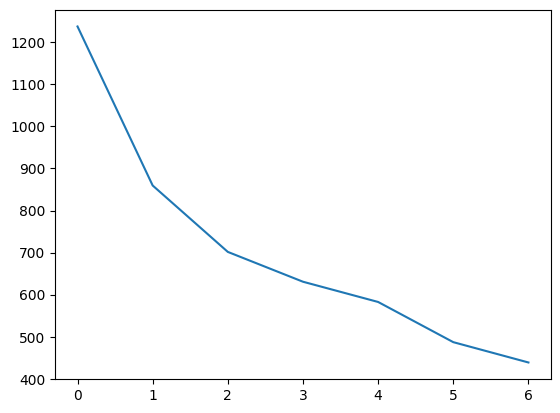

In [78]:
# Elbow-curve /SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, n_init='auto')
    kmeans.fit(data_scale)

    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
plt.plot(ssd)

In this case, we can assume that the optimal number of clusters is 3, but it needs to be clarified as the Elbow is not very prominent.

### Silhouette Analysis:

Another way to determine the number of clusters is by using Silhouette Analysis. According to the scikit-learn documentation, " can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually." Some people argue that the Silhouette Analysis is better than the Elbow Method.

- p is the mean distance to the points in the nearest cluster that the data point is not a part of.

- q is the mean intra-cluster distance to all the points in its own cluster.

- The value of the silhouette score range lies between -1 to 1.

- A score closer to 1 indicates that the data point is very similar to other data points in the cluster.

- A score of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters.

- A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [82]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, n_init='auto')
    kmeans.fit(data_scale)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(data_scale, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.3409900657109462
For n_clusters=3, the silhouette score is 0.3639133310582228
For n_clusters=4, the silhouette score is 0.31765633482047967
For n_clusters=5, the silhouette score is 0.33565192832566937
For n_clusters=6, the silhouette score is 0.3101692458600297
For n_clusters=7, the silhouette score is 0.3004104331452087
For n_clusters=8, the silhouette score is 0.284936056610633
For n_clusters=9, the silhouette score is 0.2755198882873924


Based on the information given here and some research online, determine whether k=3 is the right choice.

## Train your model:
Now train our final model with the appropriate value of k=3.

In [83]:
# k-means with k=3
kmeans = KMeans(n_clusters=3, max_iter=50, n_init='auto')
kmeans.fit(data_scale)

KMeans(max_iter=50, n_clusters=3, n_init='auto')

Then, assign the resulting labels to the Monetary, Frequency, and Recency DataFrame (before scaling).

In [84]:
# assign the label
filtered_df['Cluster_Id'] = kmeans.labels_
filtered_df.head()

,CustomerId,Amount,Frequency,Recency,Cluster_Id
0,AA-10315,5563.56,11,184,2
1,AA-10375,1056.39,15,19,1
2,AA-10480,1790.51,12,259,0
3,AA-10645,5086.94,18,55,2
4,AB-10015,886.16,6,415,0


And then try to visualize the results:

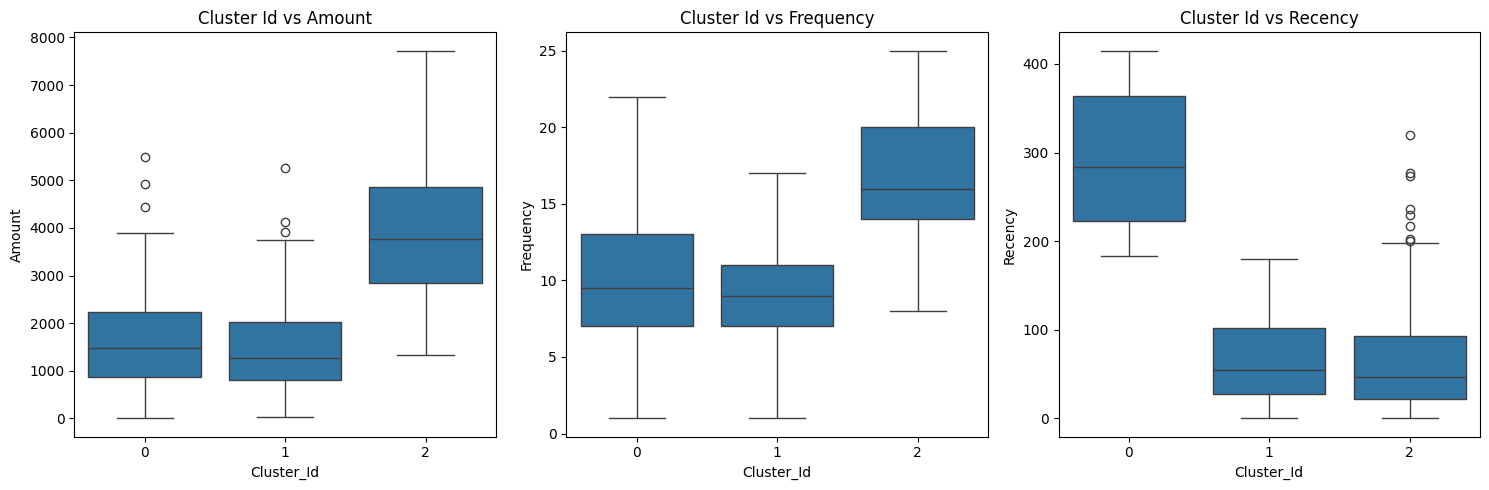

In [90]:
# Create a figure with 3 subplots arranged in 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Box plot to visualize Cluster Id vs Amount
sns.boxplot(x='Cluster_Id', y='Amount', data=filtered_df, ax=axes[0])
axes[0].set_title('Cluster Id vs Amount')

# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=filtered_df, ax=axes[1])
axes[1].set_title('Cluster Id vs Frequency')

# Box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=filtered_df, ax=axes[2])
axes[2].set_title('Cluster Id vs Recency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Consider more parameters (optional)
The above analysis is elementary: it only considers 3 elements of a dataset that contains a lot of information.

Try to think about other parameters that you could consider in the analysis that makes sense. For example: Are there any perceivable differences in behavior between Corporate and Consumer Segments? Could you deduce patterns between the product categories? Are there any noteworthy differences between the states?